In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.constants import R, g

# Analytical solution for sealing time

In [2]:
def ODE(t, phi, K, phi_c):
    """ dphi/dt = -(1-phi) * strain rate (Eq. 6) """
    return -(1 - phi) * K * phi_c**2 / (phi_c - phi)**2

In [3]:
K = 1.0  # Pressure solution kinetic constant
phi_c = 0.4  # Maximum porosity. Note: q = 2*phi_c
phi0 = 0.399  # Initial porosity

# Define time range over which to evaluate the ODE
t_max = 0.1
t_eval = np.linspace(0, t_max, 1000)

# Solve ODE
result = solve_ivp(ODE, t_span=(0, t_max), t_eval=t_eval, y0=(phi0,), args=(K, phi_c,), rtol=1e-10)
t = result["t"]
phi = result["y"][0]

<IPython.core.display.Javascript object>


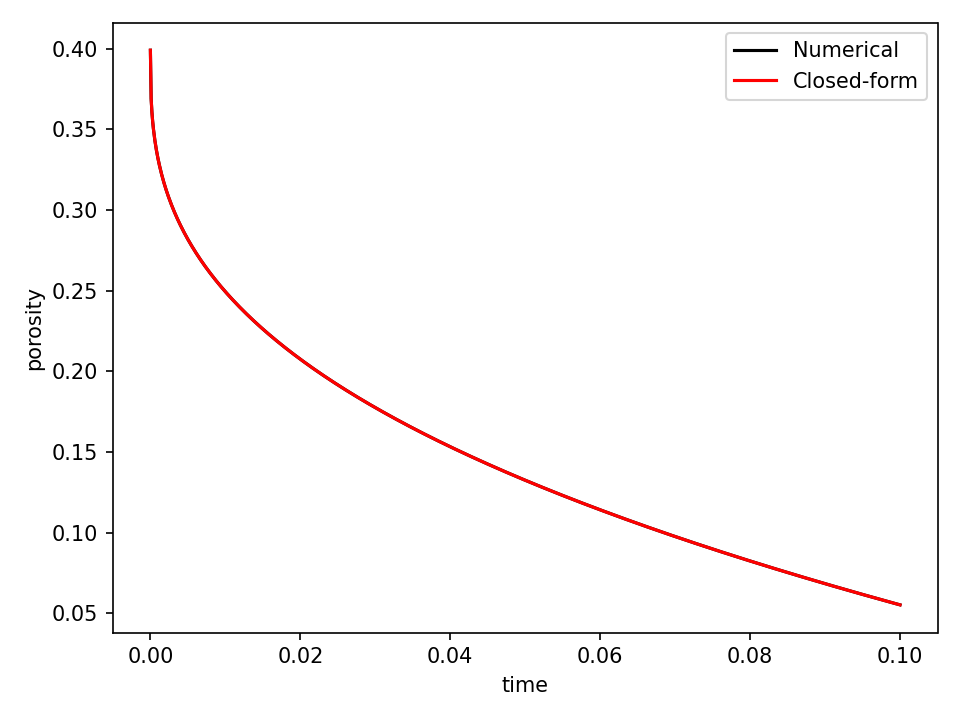

In [4]:
# Analytical solution for sealing time
# Note that phi_c and phi0 are taken independently, but one could set phi0 = phi_c
log_term = (1 - phi_c)**2 * np.log((1 - phi0) / (1 - phi))
sum_term = 0.5 * (phi0**2 - phi**2) + (1 - 2*phi_c) * (phi0 - phi)
t_closed = -(log_term + sum_term) / (K * phi_c**2)

plt.figure()
# Numerical solution
plt.plot(t, phi, "k-", label="Numerical")
# Analytical solution
plt.plot(t_closed, phi, "r-", label="Closed-form")
plt.legend()
plt.xlabel("time")
plt.ylabel("porosity")
plt.tight_layout()
plt.show()

# Monte-Carlo sampling

In [5]:
"""
Constant parameters (not sampled from random distribution)
"""

Nz = 1000  # Number of depth locations

Z = 6
F = np.pi
O = 6.43e-5  # Molar volume

# Diffusion kinetics (Eq. (7))
DS_ref = 3e-18
T_ref = 299.
Q_ref = 2.6e4
D0S = DS_ref * np.exp(Q_ref / (R * T_ref))

dTdz = 30e-3  # Geotherm [K/m]
rho = 2310.0  # Overburden density [kg/m3]

z = np.linspace(300, 7200, Nz)  # Depth range [m]

sigma_v = rho * g * z  # Overburden stress
sigma_h = 0.6 * sigma_v  # Horizontal stress
sigma_bar = sigma_v + 2 * sigma_h  # Mean stress

# Temperature range (starting at room T)
T = 293.0 + dTdz * z

# Solubility
a = 17.502
b = -4220.119
c = -0.0689
o_dol = 0.18
logK = a + b / T + c * T
C_s = 1000 * np.power(10, 0.25 * logK) * o_dol * O

In [6]:
"""
Random parameters (sampled from random distributions)
"""

Nrand = 10_000
np.random.seed(0)

# Standard normal distribution N(0, 1). 
# Specific distributions are obtained as N(mu, sigma) = sigma * N(0, 1) + mu
normal = np.random.randn(4, Nrand)

# Grain size
d_min = 5e-6
d_max = 9e-6
d = np.random.rand(Nrand) * (d_max - d_min) + d_min

# Prefactor
A_d = 0.1 * normal[0] + 4.5
A_d = np.clip(A_d, 4.1, 4.8)

# Activation energy
Q_d = 1e3 * normal[1] + 2.6e4
Q_d = np.clip(Q_d, 2.3e4, 2.9e4)

# Initial porosity
phi0 = 0.01 * normal[2] + 0.15
phi0 = np.clip(phi0, 0.12, 0.19)

# Terminal porosity
phi1 = 0.01 * normal[3] + 0.06
phi1 = np.clip(phi1, 0.03, 0.09)

In [7]:
def calc_t_seal(K, phi0, phi1):
    """ Analytical solution for the sealing time """
    log_term = (1 - phi0)**2 * np.log((1 - phi0) / (1 - phi1))
    sum_term = 0.5 * (phi0**2 - phi1**2) + (1 - 2*phi0) * (phi0 - phi1)
    t_closed = -(log_term + sum_term) / (K * phi0**2)
    return t_closed

In [8]:
# Buffer for sealing time
t_seal = np.zeros((Nrand, Nz))

# Loop over random samples
for i in range(Nrand):
    # Diffusivity-solubility
    DSC = D0S * np.exp(-Q_d[i] / (R * T)) * C_s
    # Kinetic constant
    K = (4 * np.pi * A_d[i] * Z / F) * (DSC / d[i]**3) * (sigma_bar * O / (R * T))
    # Sealing time [s]
    t_seal[i] = calc_t_seal(K, phi0[i], phi1[i])

<IPython.core.display.Javascript object>


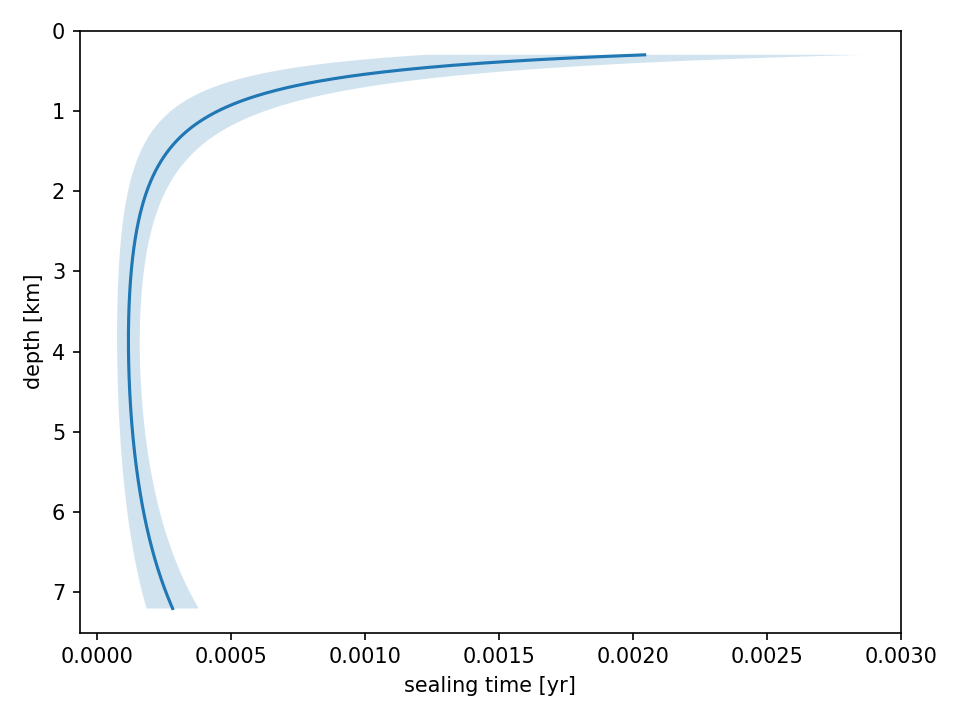

In [9]:
# Compute mean and standard deviation as a function of depth
t_mean = np.mean(t_seal, axis=0)
t_std = np.std(t_seal, axis=0)

# Number of seconds per year
t_yr = 24 * 3600 * 365.

plt.figure()
plt.fill_betweenx(z * 1e-3, (t_mean - 0.5 * t_std) / t_yr, (t_mean + 0.5 * t_std) / t_yr, alpha=0.2)
plt.plot(t_mean / t_yr, z * 1e-3)
plt.ylim((7.5, 0))
plt.xlabel("sealing time [yr]")
plt.ylabel("depth [km]")
plt.tight_layout()
plt.show()